# purpose: readin, clean, parse the gaze data; extract saccade data from gaze; break the saccade into toward/away category; transform saccade into frequency; parse the saccade data
previous: cleanELPup.ipynb

clean gaze data:
- readin the psychopy file (for tagging); blink mask (created by cleanELPup.ipynb); events; raw gaze file (x and y channels), and cleaned pupil data (created by cleanELPup.ipynb)
- mask the raw gaze data (both channels); reject the masked periods. use nearest neighbour interpolation
- reunit the data from pixel to percentage [-100,100%] on both channels

reject trials:
- created two datasets using two rejection criterias. 1. more strict dataset (used for main text) that checks for gaze drift; 2. more inclusive datasets that contains the same ID as in the cleaned pupil data (for supplement)

find saccade
- smooth the gaze array, and calculate the shifts using two methods: relative to each shift distance, and relative to the screen center
- the results from the first method is then split into toward/away based on the trial information (whether the retrocue is to the left/right); This is done for both datasets
- the toward/away shifts is transformed into frequency using rolling window average

parse:
- readin the event dataframe
- epoch the retrocue data for gaze; saccade(shifts and frequency)

save: 
- save the gaze (retrocue) and baseline period
- for both datasets: save the epoched toward/away shifts, the shifts regard to screen center (also epoched); the frequency of toward/away

upnext: pupResults.ipynb

# imports 

In [24]:
import warnings
warnings.filterwarnings("ignore")
#for handling RAM
import gc 

#stats
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import pingouin as pg


#my to go packages
import math
import random
import pandas as pd
import numpy as np

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import matplotlib.ticker as ticker


#for readin
import glob # Package for Unix-style pathname pattern expansion
import os   # Python operating system interface

#for signal processing
from scipy.interpolate import CubicSpline,interp1d
import scipy.signal as signal
import scipy.stats as stats
from scipy.signal import filtfilt, butter
from scipy.fft import rfft, rfftfreq
from scipy.stats import sem 
from scipy.stats import norm
from scipy.stats import ttest_rel

#other packages
import ast
import itertools
from itertools import groupby
from more_itertools import consecutive_groups
import more_itertools as mit
from operator import itemgetter
import statistics
from sklearn.mixture import GaussianMixture



# functions

In [25]:
#helper functions for speed array
def find_abs_speed_noSmooth(timepoint,ps): #find the raw speed array without applying any smoothing

    ds = np.zeros(len(ps))

    try:
        ps = pd.to_numeric(ps, errors='coerce').fillna(0.0) #repleace non numeric values with 0
    except AttributeError:
        ps = np.where(np.isnan(ps),0,ps)
    
    try:
        ps = ps.values
        timepoint = timepoint.values
    except AttributeError:
        pass

    prev = abs((ps[1:-1] - ps[0:-2])/(timepoint[1:-1] -timepoint[0:-2]))
    post = abs((ps[1:-1] -ps[2:])/ (timepoint[1:-1] -timepoint[2:]))
               
    ds[1:-1] = np.where(prev >= post,prev,post)
    ds[0] = abs((ps[1] - ps[0])/ (timepoint[1] - timepoint[0]))
    ds[-1] = abs((ps[-1] - ps[-2])/ (timepoint[-1] - timepoint[-2]))
    
    return ds
def find_abs_speed_pup(ps): #this is same as find_abs_speed, but now using a smoothed speed array for pupil
    #by using 5 points to calculate speed instead of 2
    ds = np.zeros(len(ps))

    try:
        ps = pd.to_numeric(ps, errors='coerce').fillna(0.0) #repleace non numeric values with 0
    except AttributeError:
        ps = np.where(np.isnan(ps),0,ps)
    
    try:
        nminus1 = ps.iloc[1:-3].values
        nplus1 = ps.iloc[3:-1].values
        nminus2 = ps.iloc[0:-4].values
        nplus2 = ps.iloc[4:].values

        ds[0] = abs(ps.iloc[1] - ps.iloc[0])
        ds[1] = abs(ps.iloc[2] - ps.iloc[1])
        ds[-1] = abs(ps.iloc[-1] - ps.iloc[-2])
        ds[-2] = abs(ps.iloc[-2] - ps.iloc[-3])
    except AttributeError:
        nminus1 = ps[1:-3]
        nplus1 = ps[3:-1]
        nminus2 = ps[0:-4]
        nplus2 = ps[4:]

        ds[0] = abs(ps[1] - ps[0])
        ds[1] = abs(ps[2] - ps[1])
        ds[-1] = abs(ps[-1] - ps[-2])
        ds[-2] = abs(ps[-2] - ps[-3])
               
    ds[2:-2] = abs((nplus1 + nplus2- nminus1 - nminus2  )/6)
    
    
    return ds
def find_rel_speed(vec):
    #this is same as find_abs_speed_pup, except relative speed

    try:
        nminus1 = vec.iloc[1:-3].values
        nplus1 = vec.iloc[3:-1].values
        nminus2 = vec.iloc[0:-4].values
        nplus2 = vec.iloc[4:].values
    except AttributeError:
        nminus1 = vec[1:-3]
        nplus1 = vec[3:-1]
        nminus2 = vec[0:-4]
        nplus2 = vec[4:]
    #calculate derivative
    d = (nplus1 + nplus2- nminus1 - nminus2  )/6

    return d

In [26]:
#other helper functions
def consecutive(data, stepsize=10,
                findSame = False): # helper function for findGazeShift, deBlink, and more
    """
    @ data = row vector
    @ stepsize =  the larger the step size, the more difference it allows for two groups
                to be considered within the same cluster
    @ findSame = if True, find concecutive data point of the same value, this is set true
                 for finding blink counts using the blink mask (a df of 0 and 1 )
    """
    # this will split an array of numbers into many subarrays of consecutive numbers
    # the stepsize controls for how close of the two numbers for them to be considered
    # in the same cluster; e.g. [1,2,3,4,5,10] would be clustered together if stepsize = 5

    #data is the array of timepoint where the saccade velocity array crossed the threshold
    if findSame:
        stepsize = 0
        return np.split(data, np.where(abs(np.diff(data)) > stepsize)[0]+1)
    return np.split(data, np.where(np.diff(data) > stepsize)[0]+1)
def smooth(x,window_len=11,window='hanning'): #smoothing function
    try:
        x = x.values
    except:
        pass
    # about np windows:
    # https://numpy.org/doc/stable/reference/routines.window.html
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    #this is to prepare the input for convolve i.e. add 1/2 window length padding before and after
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]] 
    
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    #sliding window
    y=np.convolve(w/w.sum(),s,mode='valid')
    
    #get rid of the paddings
    return y[int(window_len/2):int(-0.5*window_len)] #select the data points to get rid of the delay
def strictly_increasing(L):#check if an array is uniformly increasing
    return all(x<y for x, y in zip(L, L[1:]))
def fs(width,height):#setting plot size
    plt.rcParams['figure.figsize'] = (width,height)


In [27]:
#function used for blink identification
def mad_func(ds,mad_threshold): #calculate the median absolute diviation (MAD)
    
    """
    function that calculate the median absolute diviation (MAD)
    ---------------------------------------------
    input: 
    ds: median absolute dilation speed, which is calculated in dilation_speed_filter
    mad_threshold: the threshold of median deviation (MAD); any data that is above median dilation speed + threshold*(MAD) will be rejected
    ---------------------------------------------
    output:
    returns a float and a boolean, first is the threshold, second is the bool array
    """
    try:
        ds = np.where(np.isnan(ds),0,ds)
    except:
        ds = np.where(ds.isnull(),0,ds)
    mad = np.nanmedian(abs(ds - np.nanmedian(ds))) # median absolute deviation
    rej_threshold = np.median(ds) + mad_threshold * mad # reject data above this threshold
       
    #returning an bool array, true = rejected, false = keep
    return (abs(ds) >= rej_threshold)  , rej_threshold
def reject_outlier(pt,rejarr, minGapLen = 0.03, borderlen = 0.05, borderlenBefore = 0,
                   freq = 1000): # 
    """
  
    ---------------------------------------------
    input:
    pt: pupil timestamps from pup_raw
    rejarr: pupil diameter with nans, assigning nan to the pupil array using the output of dilation_speed_filter()
    ---------------------------------------------
    output: return a dictionary, each key is the starting time of the nan value, each value is the end time of nan
    
    """
    borderN = borderlen* freq #number of adjacent data points that needs to be rejected
    borderNbefore = borderlenBefore * freq
    gapMinN = minGapLen * freq #number of data points in the gap
    
    b = np.where(rejarr==True, np.nan,rejarr)
    idx0 = np.flatnonzero(np.r_[True, np.diff(np.isnan(b))!=0,True])
    count = np.diff(idx0)
    idx = idx0[:-1]
    valid_mask =  np.isnan(b[idx])
    out_idx = idx[valid_mask]
    out_count = count[valid_mask]
    m = out_idx + out_count-1
    out = list(zip(out_idx, m))

    if len(out) == 0:
        return out

    #if the number of consecutively rejected data satisfies as a gap, record it
    outbool = np.array([(out[i][-1] - out[i][0])> gapMinN for i in range(len(out))])
    conRejarr = np.array(out)[outbool]
    gapCorrarr = [[]]*len(conRejarr)
    
    for i in range(len(conRejarr)):
        conRejarr[i][0] = max(0,conRejarr[i][0]-borderNbefore)
        #print(conRejarr[i][-1],conRejarr[i][-1]+borderN)
        conRejarr[i][-1] = min(len(pt)-1,conRejarr[i][-1]+borderN)
        gapCorrarr[i] = np.arange(conRejarr[i][0],conRejarr[i][-1]+1)
   
    return np.array(gapCorrarr)
def blkLen(rowInput,blkLen):#counts how many blink has occured using the mask df
    #blink len default = how many consecutive points for one event to be registered as blink
    #count this as 1 blink event
    boolMask = [list(g)[0]>0 for k, g in groupby(rowInput) ]
    repeatingVal = np.array([list(g) for k, g in groupby(rowInput)])
    
    blkArr = repeatingVal[boolMask]
    blkCnt = sum([len(i) > blkLen for i in blkArr])
    return blkCnt
def medianVariance(vec):#vec is the result from find_abs_speed_pup/sacc
    try:
        val = np.nanmedian(abs(vec - np.nanmedian(vec)))
    except:
        print('F**k! medianVariance function encountered an error:')
        print('dtype of vec:' + str(type(vec)))
        print('np.nanmedian(vec) :' + str(np.nanmedian(vec)))
    return val

In [28]:
#older functions
def interpolate_blink(paddedRejIndex,paddedRejBool, timestamp,pupilsize,
                      maxGapLen = 0.5,freq = 200):#paddedRejIndex = output from reject_outlier; ..Bool is the pseudodf['paddedDsRej']
    # check for the length for each gap, if it's longer than the maximum length defined for a gap
    # then don't interpolate, just leave it blank
    interpolateIndex = paddedRejIndex[[len(i)<maxGapLen*freq for i in paddedRejIndex]]
    """ i found that it works better to not smooth the pupil size
     """
    pupilsize = np.array(smooth(pupilsize))
   
    #for each blink, select the onset/offset pupil size, as well as two equal distant time point,call it ref list
    refList = np.array([np.array([max(0,i[0] - len(i)),i[0],i[-1],min(len(timestamp)-1,i[-1] + len(i))]) for i in interpolateIndex])
    
    #use the refList to retrieve the paddedRejIndex, if more than 2 values are True, i.e. the first and last reference points
    #are also rejected data, then use the linear interpolation, else if the first and last ref points can be retrieved,
    #use cubic spline interpolation
    linearList = refList[np.sum(paddedRejBool.values[refList],axis = 1) > 2]
    cubicList = refList[np.sum(paddedRejBool.values[refList],axis = 1)== 2]
    
    #use the linearlist or cubic list, find the timestamp or pupilsize values used for interpolation
    cubictss = timestamp.values[cubicList]
    cubicarr = pupilsize[cubicList]#pupilsize.values[cubicList]
    
    lineartss = timestamp.values[linearList]
    lineararr = pupilsize[linearList]#pupilsize.values[linearList]
    
    #calculate the interpolated values; Index is the array of timestamp arrays, FuncList is the interpolated value
    cubicIndex = [np.array(timestamp.iloc[cubicList[i][1]:cubicList[i][2]]) for i in range(len(cubicList))]
    csFuncList = [CubicSpline(cubictss[i],cubicarr[i])(cubicIndex[i]) for i in range(len(cubicList))]

    linearIndex = [np.array(timestamp.iloc[linearList[i][1]:linearList[i][2]]) for i in range(len(linearList))]
    lFuncList = [interp1d(lineartss[i],lineararr[i])(linearIndex[i]) for i in range(len(linearList))]
   
    return cubicIndex,csFuncList,linearIndex,lFuncList
def dsclean(thisdf,arr):
    """
    this is the main function for reject, clean, and interpolate
    thisdf is the df of the specific subject
    #1st it, arr = 'diameter_3d', 2+ it, arr = 'diameter_3dNew'
    
    note: outside the function, these four variables needs to be specified, e.g.
    maxGapLen = 1; minGapLen = 0.0 ; freq = 1000; gapMinN = minGapLen*freq; gapMaxN = maxGapLen*freq
    
    
    """
    #1st ite
    arr = thisdf[arr] #1st it, arr = diameter_3d, 2+ it, arr = diameter_3dNew
    rejarr,rejThreshold = mad_func(find_abs_speed(thisdf.pupil_timestamp,arr),3.5)    #need to get rid of zeros
    thisdf['dsRej'] = (rejarr == True) | (arr.isnull()) | (arr == 0)

    paddedDsRej = reject_outlier(thisdf.pupil_timestamp,thisdf.dsRej,minGapLen = minGapLen,borderlen=0.025,freq= 1000)
    thisdf['paddedDsRej'] = np.where(thisdf.index.isin(np.concatenate(paddedDsRej)),True,False)

    gapCorrarr = np.where(thisdf.paddedDsRej)[0]
    #the sum of sublist in gapCorrarrparsed is the same length as the gapCorrarr
    gapCorrarrParsed = [np.array(list(group)) for group in mit.consecutive_groups(gapCorrarr)] 

    #if the gap is shorter than minimum length, don't count it as a gap (but i've set min gap len to 0)
    outbool = np.array([(gapCorrarrParsed[i][-1] - gapCorrarrParsed[i][0])> gapMinN for i in range(len(gapCorrarrParsed))])
    gapCorrarrParsed = np.array(gapCorrarrParsed)[outbool]
    #correct the paddedDsRej, excluding shorter-than-gap values, i.e. set those to false
    thisdf['paddedDsRejNoGap'] = np.where(thisdf.index.isin(np.concatenate(gapCorrarrParsed)),True,False)

    #also don't interpolate for gap length longer than maximum gap len
    #first iteration use diameter 3d
    csts,csi,lts,li = interpolate_blink(paddedRejIndex = gapCorrarrParsed,
                                        paddedRejBool = thisdf['paddedDsRejNoGap'],
                                        timestamp = thisdf.pupil_timestamp,
                                        pupilsize = arr,
                                        freq = 1000) #this pupilsize is different for iteretions

    #for this 1st iteration, make a copy of diameter 3d to add the interpolated data
    thisdf['diameterThisIter'] = arr #this pupilsize is different for iteretions
    try:
        thisdf.loc[np.where(thisdf['pupil_timestamp'].isin(np.concatenate(csts)))[0],'diameterThisIter'] = np.concatenate(csi)
        thisdf.loc[np.where(thisdf['pupil_timestamp'].isin(np.concatenate(lts)))[0],'diameterThisIter'] = np.concatenate(li)
    except ValueError: 
        print('no array to concat')
    """
    minPup = np.mean(thisdf['diameterThisIter']) - 3*np.std(thisdf['diameterThisIter'])
    maxPup = np.mean(thisdf['diameterThisIter']) + 3*np.std(thisdf['diameterThisIter'])

    #also reject periods of pupil size that's larger the 3 sd away from the median, callit diameter_3dNew
    thisdf['diameter_3dNew'] = np.where(((thisdf['diameterThisIter']<minPup)|(thisdf['diameterThisIter']>maxPup)),0, thisdf['diameterThisIter'] )
    """
    return thisdf
def tlclean(thisdf,windown = 501,mad = 10,
            psCol = 'diameterThisIter',tsCol = 'pupil_timestamp',psColNew = 'diameter_3dNew'):
    
    #make trendline by interpolating and smoothing
    cs = CubicSpline(thisdf[tsCol][~thisdf[psCol].isnull()].values,
                   thisdf[psCol][~thisdf[psCol].isnull()].values)
    interp = cs(thisdf[tsCol])
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(thisdf[psCol] -smoothed,mad)[0]
    thisdf['dsRej'] = (tlmad == True) | (thisdf[psCol].isnull() == True) | (thisdf[psCol] == 0)

    #don't pad the tl deviations
    arr = thisdf[psCol]
    gapCorrarr = (np.where(thisdf.dsRej)[0]) 
    #the sum of sublist in gapCorrarrparsed is the same length as the gapCorrarr
    gapCorrarrParsed = np.array([np.array(list(group)) for group in mit.consecutive_groups(gapCorrarr)]) 

    #preparation for interpolation
    interpolateIndex = gapCorrarrParsed[[len(i)<maxGapLen*freq for i in gapCorrarrParsed]]
    refList = np.array([np.array([max(0,i[0] - len(i)),i[0],i[-1],min(len(thisdf[tsCol])-1,i[-1] + len(i))]) for i in interpolateIndex])
    increasingList = np.array([strictly_increasing(i) for i in refList])

    linearList = refList[(np.sum(thisdf['dsRej'].values[refList],axis = 1) > 2) | (increasingList== False) ]
    cubicList = refList[(np.sum(thisdf['dsRej'].values[refList],axis = 1)== 2) & (increasingList)]

    #use the linearlist or cubic list, find the thisdf[tsCol] or arr values used for interpolation
    cubictss = thisdf[tsCol].values[cubicList]
    cubicarr = arr.values[cubicList]
    #correct for nan
    cubicList = cubicList[np.isnan(cubicarr).sum(axis = 1) !=1]##
    cubictss = cubictss[np.isnan(cubicarr).sum(axis = 1) !=1]##
    cubicarr = cubicarr[np.isnan(cubicarr).sum(axis = 1) !=1] ##

    #for linear
    lineartss = thisdf[tsCol].values[linearList]
    lineararr = arr.values[linearList]
    #correct for nan
    linearList = linearList[np.isnan(lineararr).sum(axis = 1) !=1]##
    lineartss = lineartss[np.isnan(lineararr).sum(axis = 1) !=1]##
    linearr = lineararr[np.isnan(lineararr).sum(axis = 1) !=1] ##


    #calculate the interpolated values; Index is the array of thisdf[tsCol] arrays, FuncList is the interpolated value
    cubicIndex = [np.array(thisdf[tsCol].iloc[cubicList[i][1]:cubicList[i][2]]) for i in range(len(cubicList))]
    csFuncList = [CubicSpline(cubictss[i],cubicarr[i])(cubicIndex[i]) for i in range(len(cubicList))]

    linearIndex = [np.array(thisdf[tsCol].iloc[linearList[i][1]:linearList[i][2]]) for i in range(len(linearList))]
    lFuncList = [interp1d(lineartss[i],lineararr[i])(linearIndex[i]) for i in range(len(linearList))]

    #for this 1st iteration, make a copy of diameter 3d to add the interpolated data
    thisdf[psColNew] = arr #copy the old ps column, then modify it using the interpolated values
    thisdf.loc[np.where(thisdf[tsCol].isin(np.concatenate(cubicIndex)))[0],psColNew] = np.concatenate(csFuncList)
    thisdf.loc[np.where(thisdf[tsCol].isin(np.concatenate(linearIndex)))[0],psColNew] = np.concatenate(lFuncList)
    
    return thisdf
def tl(thisdf,windown = 501,mad = 10,
       psCol = 'diameterThisIter',tsCol = 'pupil_timestamp',psColNew = 'diameter_3dNew'):
    #make trendline by interpolating and smoothing
    cs = CubicSpline(thisdf[tsCol][~thisdf[psCol].isnull()].values,
                   thisdf[psCol][~thisdf[psCol].isnull()].values)
    interp = cs(thisdf[tsCol])
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(thisdf[psCol] -smoothed,mad)[0]
    return tlmad
def tlFinal(x,y,windown = 101,mad = 10):
    #this is for doing trialwise tl rejection, not very necessay but since the input format
    #is slightly different from the tl function, i'm including it as a sepearte one
    cs = CubicSpline(x[~np.isnan(y)],
                    y[~np.isnan(y)])
    interp = cs(x)
    smoothed = smooth(interp,windown)
    #tlmad = bool list
    tlmad = mad_func(y-smoothed,mad)[0]
    return tlmad

In [125]:
#core functions
def deBlink(rawPup,timestamp,
            returnMask = False,
            maxGapt = 2,
            minGapt= 0.003,
            freq = 1000,
            borderlenBef=0.001,
            borderlenAft=0.01,
            clusterLapse = 0.15,
            plotSteps = False,
            madThreshold = 3.5,
            ):
    """
    #this function clean the pupil array, and generate a boolean blink mask array
    @ rawPup = each row in the epoched pupil table
    @ timestamp = 
    @ returnMask: if true, return the boolean mask only (this is necessday because df.apply can't return two dfs)
    @ minGapt = 
    @ freq = 
    @ borderlenBef = paddings to add after each blink
    @ borderlenAft = paddings to add before each blink
    @ clusterLapse = larger value will count more distant blinks as one, resulting in more data rejected
    @ plotSteps = if True, generate a plot for the cleaning step
    @ madThreshold = speed threshold for rejection
    """
    #find the raw rej arr; This use a smoothed pupil change speed array to find the threshold
    #crossings
    rejarr = mad_func(find_abs_speed_pup(rawPup),madThreshold)[0] | (rawPup < 2000)

    #initialize two mask array, these will store the processed blink mask
    rejarr_padded = np.zeros(len(rejarr))
    rejarr_blkMask = np.zeros(len(rejarr))

    #pad the mask
    try:
        np.put(rejarr_padded, np.concatenate(reject_outlier(timestamp, rejarr, minGapLen= minGapt, borderlenBefore=borderlenBef,
                                                    borderlen=borderlenAft)), 1, mode='clip')
    except ValueError:
        rejarr_padded = rejarr

    #identify clusters in the mask (if two blink are too close, count them as one cluster and mask off the lapse between)
    #put the resulting mask into rejarr_blkMask, this will be returned as output
    try:
        consecutiveBlkFilter = np.array([np.arange(i[0], i[-1]+1) for i in consecutive(np.where(rejarr_padded)[0], 
                                                                                       stepsize= clusterLapse*freq)])
        np.put(rejarr_blkMask, np.concatenate(consecutiveBlkFilter), 1, mode='clip')
    except ValueError:
        rejarr_blkMask = rejarr_padded
    except IndexError: 
        return rawPup
        
    blkMask = rejarr_blkMask.copy()

    #just return the mask if necessary
    if returnMask:
        return blkMask

    """clean"""
    #use this mask to clean the pupil, mask off the data in blink
    #creating a copy for the plot because we will change the value of maskedPup 
    maskedPup_plt = np.where(rejarr_blkMask, np.nan, rawPup) 
    maskedPup = maskedPup_plt.copy() 

    """interpolation"""
    # reshape the clusted blink mask into arrays of clusted index, if its lenth if larger than the 
    # maximum gap lenth * frequency, then don't interpolate for this cluster, just leave it blank
    rejCluster = consecutive(np.where(rejarr_blkMask)[0], 1)
    rejCluster = np.array([k for k in rejCluster if len(k) < maxGapt*freq])

    #find four index for interpolation
    indexForInterp = np.array([np.array([max(0, i[0] - len(i)),
                                        max(0, i[0]-1),
                                        min(i[-1]+1, len(timestamp)-1),
                                        min(len(timestamp)-1, i[-1] + len(i))]) for i in rejCluster])
    
    #when applying this function to a df, sometime it required the input to be in specific format
    try:
        timestamp = timestamp.values
        rawPup = rawPup.values
    except AttributeError:
        timestamp = np.array(timestamp)
        rawPup = np.array(rawPup)
    
    #run the following if there there are available blink clusters for interpolation, interpolate
    try:
        #get the timestamp and pupil size (masked) for creating the interpolation function
        tsForInterp = timestamp[indexForInterp]
        cleanPupForInterp = maskedPup[indexForInterp]
        
        #get the timestemp for exptrapolate the missing pupil size
        tsForExtrap = [timestamp[i] for i in rejCluster]
        
        #for each available blink cluster,try use the cubic spline interpolation of 4 points
        #but if any point if nan, then use linear; but if it still can't (e.g. only one data point availble)
        #then don't interpolate, leave it as nan
        for i in range(len(rejCluster)):
            try:
                pupExtrapolated = CubicSpline(tsForInterp[i], cleanPupForInterp[i])(tsForExtrap[i].astype(float))
            except ValueError:
                try:  # if cant find reference points, use linear interpolation
                    pupExtrapolated = interp1d(tsForInterp[i][1:3], cleanPupForInterp[i][1:3])(tsForExtrap[i].astype(float))
                # if still gives error, then dont interpolate (usually the case with trial start/end)
                except ValueError:
                    pupExtrapolated = np.nan
            #fill each blink cluster with interpolated pupil value
            maskedPup[rejCluster[i]] = pupExtrapolated
    except IndexError:
        pass

    if plotSteps:
        fig, ax = plt.subplots(nrows=5)
        #plot speed and threshold of rejection
        sns.scatterplot(x= timestamp, y= find_abs_speed_pup(rawPup), ax=ax[0])
        ax[0].hlines(mad_func(find_abs_speed_pup(rawPup), 3.5)[1],
                    xmin=timestamp[0], xmax=timestamp[-100], colors='r')
        #plot the unfilted mask
        sns.scatterplot(x=timestamp, y=rawPup, hue=rejarr, ax=ax[1])
        #plot the filtered mask
        sns.scatterplot(x=timestamp, y=rawPup, hue=rejarr_blkMask, ax=ax[2])
        #plot the pupil data after it's been masked
        sns.scatterplot(x=timestamp, y=maskedPup_plt, ax=ax[3])
        #plot the interpolated pupil size
        sns.scatterplot(x=timestamp, y=maskedPup, ax=ax[4])
        
        ax[1].sharex(ax[0])
        ax[2].sharex(ax[0])
        ax[3].sharex(ax[0])
        ax[4].sharex(ax[0])

    
    return maskedPup
def findGazeShift(xvec,threshold = 6, countTogether = 50, 
                   baseline = None, winlen = 50,shiftmin = 2.14,
                   baselinePadding = 0):
    """
    @ xvec =  the gaze position (it should be each row in the saccRetro_X df)
    @ threshold = the velocity filter threshold
    @ countTogether = the maximum delay for two gaze shift cluster to be count as one
    @ baseline = if none, calculate relative baseline  (i.e. in regard to position before and after shift)
                else it should be a list of index to indicate baseline rage, e.g. [500,1000]
    @ winlen = for the onset of each identified gazeshift cluster, get the [-winlen,0] and [winlen, 2+ winlen]
            to calculate the mean gaze position before and after the shift occur
    @ shiftmin = the minimum shift in gaze position for it to be considered as a real shift
            default = 2.14 pixel = 0.057 visual degree
    @ baselinePadding = the padding to add before the identified gaze shift, this is only meaningful if baseline
                        is None (i.e. the shift regarding to gaze position before and after)
    
    """
    # get speed vector
    # since we are using 4 time points to calculate the speed array (see find abs speed sacc function)
    # the len of dx, dy is 4 points less than the length of xvec. 
    dx = find_abs_speed_sacc(xvec)
    #get threshold, then get a boolean array, for finding threshold crossing clusters
    thresholdx = [np.nanmedian(dx) + medianVariance(dx) *threshold,np.nanmedian(dx) - medianVariance(dx) *threshold]
    cx = (dx>thresholdx[0]) | (dx < thresholdx[1])
    cx = np.r_[False,False,cx,False,False] #correct for the four lost points


    # Deselect period at the beginning and the end of the position array i.e.掐头去尾
    # and re-identify the saccade cluster after applying both masks
    # if two clusteres are close enough (50ms), then count them as one
    onsetoffsetmask = np.r_[np.zeros(winlen + baselinePadding),np.ones(len(cx) - 3*winlen - 2* baselinePadding),np.zeros(2*winlen + baselinePadding)].astype(bool) #to deselect data in the first and last 50ms 
    maskedcx = np.where(cx & onsetoffsetmask)[0] 
    msCluster = consecutive(maskedcx,countTogether)

    # initialize the output array with zeros, calculate the mean pos before and after the shift
    gazeshift = np.zeros(len(xvec))    

    try:
        for i in msCluster:
            #if user doesn't provide a baseline value, use relative baseline
            if baseline == None:
                befIndex = [i[0] - winlen - baselinePadding,i[0]- baselinePadding]
            else:
                befIndex = baseline
            try:
                posbef = np.nanmean(xvec.iloc[befIndex[0] : befIndex[1]])
                posaft = np.nanmean(xvec.iloc[i[0] + winlen + baselinePadding : i[0] + 2*winlen + baselinePadding]) 

            except AttributeError: # this is to account for when using df.apply(raw = True),xvec is an array, not series
                posbef = np.nanmean(xvec[befIndex[0] : befIndex[1]])
                posaft = np.nanmean(xvec[i[0] + winlen + baselinePadding: i[0] + 2*winlen + baselinePadding]) 

            if abs(posaft - posbef) > shiftmin: 
                #toss away a ms if its less than a minimum visual degree 
                gazeshift[i[0]] = posaft - posbef 
            else:
                pass
    except IndexError: #i.e. if msCluster is empty, it gives error when trying to index i[0], in this case just return the 0 array
        return gazeshift
    return gazeshift
def eDist(a,b): #eucleadian distance
    return np.sqrt(a**2+b**2)
def findGazeShift2d(xvec,yvec,threshold = 6, countTogether = 50, 
                   baseline = None, winlen = 50,shiftmin = 0.2,
                   baselinePadding = 0,shiftWhere = False,):
    """
    @ xvec =  the gaze position horizontal channel
    @ yvec = the gaze position vertical channel
    @ threshold = the velocity filter threshold
    @ countTogether = the maximum delay for two gaze shift cluster to be count as one
    @ baseline = if ***none***, calculate relative baseline  (i.e. in regard to position before and after shift)
                if ***list***, it indicate baseline rage, e.g. [500,1000]
                if ***numeric***, use the numeric value as baseline
    @ winlen = for the onset of each identified gazeshift cluster, get the [-winlen,0] and [winlen, 2+ winlen]
            to calculate the mean gaze position before and after the shift occur
    @ shiftmin = the minimum shift in gaze position for it to be considered as a real shift
            default = 0.2% 
    @ baselinePadding = the padding to add before the identified gaze shift, this is only meaningful if baseline
                        is None (i.e. the shift regarding to gaze position before and after)
    @ shiftWhere = if True, only return the index where shift occurs. This is useful if use needs to combine
                    the horizontal and vertical gaze arrays. 
                    
    """
    # get speed vector
    # since we are using 4 time points to calculate the speed array (see find abs speed sacc function)
    # the len of dx, dy is 4 points less than the length of xvec. 
    dx = find_abs_speed_pup(xvec).astype(float)
    dy = find_abs_speed_pup(yvec).astype(float)
    dxySqrt = eDist(dx,dy)

    #get threshold, then get a boolean array, for finding threshold crossing clusters
    thresholdx = np.nanmedian(dxySqrt) + medianVariance(dxySqrt) *threshold
    cx = dxySqrt>thresholdx
    
    # Deselect period at the beginning and the end of the position array i.e.掐头去尾
    # and re-identify the saccade cluster after applying both masks
    # if two clusteres are close enough (50ms), then count them as one
    onsetoffsetmask = np.r_[np.zeros(winlen + baselinePadding),np.ones(len(cx) - 3*winlen - 2* baselinePadding),np.zeros(2*winlen + baselinePadding)].astype(bool) #to deselect data in the first and last 50ms 
    maskedcx = np.where(cx & onsetoffsetmask)[0] 
    msCluster = consecutive(maskedcx,countTogether)
    
    # initialize the output array with zeros, calculate the mean pos before and after the shift
    gazeshift = np.zeros(len(xvec))   

    # if user only needs to know the location where shift occured, return a boolean array
    # where 1 =  shift occur, 0 = no shift
    if shiftWhere:
        try:
            fillLoc = np.array([i[0] for i in msCluster]) 
            gazeshift[fillLoc] = 1
        except IndexError:
            pass
        return gazeshift

    try:
        for i in msCluster:
            #if user doesn't provide a baseline value, use relative baseline
            if baseline == None:
                befIndex = [i[0] - winlen - baselinePadding,i[0]- baselinePadding]
            else:
                befIndex = baseline
            
            #calculate gaze position before the shift occured 
            if type(baseline) != int:
                try:
                    posbef = np.nanmean(xvec.iloc[befIndex[0] : befIndex[1]])
                except AttributeError: # this is to account for when using df.apply(raw = True),xvec is an array, not series
                    posbef = np.nanmean(xvec[befIndex[0] : befIndex[1]])
            else: #if user decide to use a numerical value as the baseline, use that
                posbef = baseline

            #calculate the gaze position afte the shift
            try:
                posaft = np.nanmean(xvec.iloc[i[-1] : i[-1] + winlen]) 
            except:    
                posaft = np.nanmean(xvec[i[-1]: i[-1] + winlen]) 

            if abs(posaft - posbef) > shiftmin: 
                #toss away a ms if its less than a minimum visual degree 
                gazeshift[i[0]] = posaft - posbef 
            else:
                pass
    except IndexError: #i.e. if msCluster is empty, it gives error when trying to index i[0], in this case just return the 0 array
        return gazeshift
    return gazeshift

In [30]:
#this is originally used to linearly interpolate 
#missing saccade data
def linearInterpolate(x,y,method = 'linear'):
    """
    methods needs to be one of the scipy.interpolate.interp1d methods
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
    """
    #if the entire trial is nan, return nan
    if np.isnan(np.array(y)).sum() == len(y):
        interp = np.empty(len(y))
        interp[:] = np.nan
        return interp
    #else,interpolate
    try:
        li = interp1d(x[~y.isnull()],
                        y[~y.isnull()],
                        fill_value="extrapolate",kind = method)
        interp = li(x)
    except AttributeError: #handling np.array and pandas df conversion
        li = interp1d(x[~np.isnan(y)],
                        y[~np.isnan(y)],fill_value="extrapolate",kind = method)
        
    interp = li(x)
    return interp

In [31]:
#plotting function
def legend_without_duplicate_labels(ax,locVal = 'best'):
    #https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),loc = locVal)
def deBlinkSample(rawPup, samplesize = 10): #plot n trial samples with the deblink process
    fs(12,12)
    select = np.random.randint(0,len(rawPup),size = samplesize)

    #select some smaple 
    sample_raw = rawPup.iloc[select,1:]

    #Clean once
    cleanOnceSample = sample_raw.apply(lambda x: deBlink(rawPup = x.astype(float),timestamp = np.linspace(0,5,len(x)),
                                                clusterLapse = 0.05, borderlenAft = 0.2,
                                                borderlenBef= 0.05,madThreshold = 4),axis = 1,raw = True)

    #second clean
    onceSmoothSample = cleanOnceSample.rolling(11,min_periods=1,center  = True,axis =1).mean()
    cleanTwiceSample = onceSmoothSample.apply(lambda x: deBlink(rawPup = x,timestamp = np.linspace(0,5,len(x)),
                                            borderlenBef = 0.05,borderlenAft = 0.05,minGapt = 0.002,
                                            clusterLapse = 0.05,madThreshold = 6),axis =1,raw = True)
    fig,ax = plt.subplots(nrows = 3)

    x = np.linspace(0,5,5000)
    [ax[0].plot(x,sample_raw.iloc[i,:],alpha = 0.8) for i in range(len(select))]
    [ax[1].plot(x,cleanOnceSample.iloc[i,:],alpha = 0.84,linewidth = 2) for i in range(len(select))]
    [ax[2].plot(x,cleanTwiceSample.iloc[i,:],alpha = 0.8,linewidth = 2) for i in range(len(select))]

    ax[1].set_ylim(ax[2].get_ylim())
    ax[0].set_ylim(ax[2].get_ylim())

    plt.show()
def pupilPlot(normPup,blPup, 
              eventt = 3,
              blt  = 0.1,
              freq = 1000,
              type = 'grand',
              levels = ['cue_blk_validity','cued_item'],
              pltRatio = [0.2,3], pltN = 3,
              eventBoundary = [0,0.5,2.5],
              eventName = ['retrocue','delay','probe'],
              blHeight = None,
              cList = [],
              figH = 5.5, figW = 16,
              tightPlot = True,
              textSize = 12,
              ):
    """
    @ normPup = normalized pupil df with trial info columns in the end
    @ blPup = the pupil df with the baseline
    @ eventt = the time for the event of interest
    @ blLen = the time for the baseline
    @ freq = sampling frequency, defalut 1000
    @ type = the type of plot, 
           - grand avg: ;
           - subj avg: ;
    @ levels = the group by levels, e.g. block validity and cued item
    @ pltRatio = ratio for the plot for baseline and event
    @ pltN = how many plots, default 3
    @ eventBoundary = use to plot vertical lines on the plot to represent certain events
    @ eventName = the text label for these events
    @ blHeight = ylim for the baseline plots, if None, set ylim using max and min
    @ cList = the color list used for plots; default color- the ones i carefully preseletced, very pretty
    @ figH = figure height for each plot, default 5.5
    @ figW = figure width, default 16
    @ tightPlot = if true, set the plot layout to be tighter
    @ textSize = the text label on the plot size
    --------------
    return NormMean: the groupby df
    """
    eventLen = int(eventt*freq)
    blLen = int(blt*freq)

    if not type in ['grand','subj']:
        raise 'Your plot should either be grand avg or subj avg'
    if len(eventBoundary) != len(eventName):
        raise 'your event name array should be the same size as your event boundary(time) array'
    if type == 'grand':
        normmean = normPup.groupby(levels).mean().iloc[:,:eventLen]
        norm_sterr = normPup.groupby(levels).sem().iloc[:,:eventLen]
        norm_upper = normmean.iloc[:,:] +norm_sterr.iloc[:,:] 
        norm_lower = normmean.iloc[:,:] -norm_sterr.iloc[:,:] 
        try:
            normmeanBL = blPup.groupby(levels).mean().iloc[:,:blLen]
            norm_sterrBL = blPup.groupby(levels).sem().iloc[:,:blLen]
            norm_upperBL = normmeanBL.iloc[:,:] +norm_sterrBL.iloc[:,:] 
            norm_lowerBL = normmeanBL.iloc[:,:] -norm_sterrBL.iloc[:,:]
        except:
            normmeanBL = None
            norm_sterrBL = None
            norm_upperBL = None
            norm_lowerBL = None
        #the mean df will be returned
        returnMean = normmean    
        returnSd = norm_sterr
    elif type == 'subj':
        subj_levels = levels + ['subj']
        normmean = normPup.groupby(subj_levels).mean().iloc[:,:eventLen].groupby(levels).mean()
        norm_sterr = normPup.groupby(subj_levels).mean().iloc[:,:eventLen].groupby(levels).sem()
        norm_upper = normmean.iloc[:,:] +norm_sterr.iloc[:,:] 
        norm_lower = normmean.iloc[:,:] -norm_sterr.iloc[:,:] 
        try:
            normmeanBL = blPup.groupby(subj_levels).mean().iloc[:,:blLen].groupby(levels).mean()
            norm_sterrBL = blPup.groupby(subj_levels).mean().iloc[:,:blLen].groupby(levels).sem()
            norm_upperBL = normmeanBL.iloc[:,:] +norm_sterrBL.iloc[:,:] 
            norm_lowerBL = normmeanBL.iloc[:,:] -norm_sterrBL.iloc[:,:]
        except:
            normmeanBL = None
            norm_sterrBL = None
            norm_upperBL = None
            norm_lowerBL = None
            
        #the subj df will be returned
        returnMean = normPup.groupby(subj_levels).mean().iloc[:,:eventLen]
        returnSd =  normPup.groupby(subj_levels).sem().iloc[:,:eventLen]

    condN = normmean.shape[0]
    #if color list is not right length, use sns generated color
    if len(cList) < condN:
        print('input color list is too short, plot default color ')
        cList = sns.color_palette("flare",n_colors = condN)
     
    #setting up plotting params
    fs(figW,pltN*figH) #set figure size
    fig,ax = plt.subplots(nrows= pltN, ncols=2, sharex=False, sharey = False,
                          gridspec_kw={'width_ratios': pltRatio,})
    x = np.linspace(0,eventt,norm_sterr.shape[1])
    try:
        xBL = np.linspace(0,blt,norm_sterrBL.shape[1])
        if blHeight == None:
            blHeight = [norm_lowerBL.min().min(), norm_upperBL.max().max()]
    except:
        xBl = 0
        blHeight = 0

    #plot mean plot for the baseline and for the trial
    try:
        [ax[i//2][0].fill_between(xBL,norm_upperBL.iloc[i,0:norm_sterrBL.shape[1]],norm_lowerBL.iloc[i,0:norm_sterrBL.shape[1]],
                            color = cList[i],alpha = 0.2,)  for i in range(condN)]
        [ax[i//2][0].plot(xBL,normmeanBL.iloc[i,0:norm_sterrBL.shape[1]],linewidth = 2.5,color = cList[i],) for i in range(condN) ]
        [ax[i][0].set_ylim(blHeight) for i in range(pltN)]
    except:
        print('no baseline passed in')

    [ax[i//2][1].fill_between(x,norm_upper.iloc[i,0:norm_sterr.shape[1]],norm_lower.iloc[i,0:norm_sterr.shape[1]],
                        color = cList[i],alpha = 0.1, )  for i in range(condN)]
    [ax[i//2][1].plot(x,normmean.iloc[i,0:norm_sterr.shape[1]],color = cList[i],linewidth = 2,) for i in range(condN) ]
    
    
    #add vertical line and text
    for ff in range(pltN):
        ax[ff][1].vlines(eventBoundary,norm_lower.min().min(),
                         norm_upper.max().max(),linestyles = 'dashed',colors= 'black')
    for i,m in zip(eventBoundary,eventName):
        ax[0][1].text(i,norm_upper.max().max(),m,c = 'black',size = textSize)
    
    #make the plots tighter
    if tightPlot:
        plt.subplots_adjust(hspace = 0.1)
        plt.subplots_adjust(wspace = 0.06)
        
    #plt.xticks(fontsize= figW, )
    plt.show()

    return returnMean,returnSd

In [32]:
# for behavioral response from psychopy

def find_click_time(click,time):
    try:
        rt = time[np.nonzero(click)[0][0]]
    except IndexError:
        rt = np.nan
    return rt

# load params

In [16]:
pd.set_option('display.max_columns', 500)


In [17]:
#read in the mega df
local_username = 'yud070'
pathEL = 'Z:/LiteBrite_YueyingDong/22AK01ELRaw_tracker/'
pathpy = 'Z:/LiteBrite_YueyingDong/22AK01ELRaw_psychopy/'

readIn = [f for f in os.listdir(pathEL)]

In [18]:
relevantCols = ['RECORDING_SESSION_LABEL','AVERAGE_GAZE_X',
       'AVERAGE_GAZE_Y','AVERAGE_PUPIL_SIZE','EYE_TRACKED','IP_LABEL','IP_START_TIME',
      'LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','SAMPLE_MESSAGE','TIMESTAMP','TRIALID']
pupCols = ['EYE_TRACKED','LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','AVERAGE_PUPIL_SIZE',
           'IP_LABEL','TIMESTAMP','TRIALID']

In [19]:
#plotting params // pending refractor
ts = [1000,1250,1750,2250,4250,4750] #stim onset, rest, retrocue, delay, probecue

stim_ts = 0.25 
precue_ts = 0.5 + stim_ts
retrocue_ts = 0.5 + precue_ts
post_cue_ts = 2 + retrocue_ts
probe_cue = 0.5 + post_cue_ts
probe_ts = 3 + post_cue_ts
iti = 0.5 + probe_ts

epoch_array = np.array([0,stim_ts,precue_ts,retrocue_ts,post_cue_ts,probe_cue])
epoch_name = ['stim','rest','retrocue','rest','probe_cue','probe']


In [20]:
#some specified params
leftEyeSubj = ['173','175']
rightEyeSubj = ['183','185']

#events
events = ['fixateRest','stim','precueRest', 'retrocue',
                            'postcueRest','probecue', 'probe', 'ITI','trialEnd']
eventIndex = [0,1000,1250, 1750,2250,4250,4750,7750,8250]
eventInfo = dict(zip(events,eventIndex))

In [21]:
#take the first 5s in each recording, though the interest period is [0.5,4.75], but the padding
#is included for better interpolating

#params for reading in
included = 5000

#params for cleaning
sdThreshold = 6
pltAll = True
interpCorrection = np.zeros(len(readIn))
maxGapLen = 0.5
minGapLen = 0.0
freq = 1000
gapMinN = minGapLen*freq

In [22]:
#for plotting
cList = ['#fda48c','#f23908','#93648f','#33202a','#66b3ba','#03838f',]
cDict = {"['high']":'#f23908',"['medium']":'#03838f',"['low']":'#593247'} #{"['high']":'red',"['medium']":'green',"['low']":'blue'}


# readIn Files

In [106]:
pathUnparsed = 'Z:/LiteBrite_YueyingDong/temp/unparsed/'

In [82]:
#read behav
psyFull = pd.read_csv('Z:/LiteBrite_YueyingDong/temp/cleanBehav.csv').iloc[:,1:]
psyFull.set_index('identifier',inplace=True)


In [83]:
psyFull['cue_posi'] = psyFull.cue_posi.replace({0:'right',1:'left'})

### readin mask

In [7]:
maskClean = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/mask/cleanMask.csv').iloc[:,1:]

### readin events

In [105]:
eventDf = pd.concat((pd.read_csv(f).iloc[:,1:] for f in glob.glob(pathUnparsed + 'event'+'/*.csv')), ignore_index=True)

### readin gaze

In [9]:
saccFullTrial_x_raw = pd.concat((pd.read_csv(f).iloc[:,1:] for f in glob.glob(pathUnparsed + 'saccX'+'/*.csv')), ignore_index=True)
saccFullTrial_y_raw = pd.concat((pd.read_csv(f).iloc[:,1:] for f in glob.glob(pathUnparsed + 'saccY'+'/*.csv')), ignore_index=True)

### readin cleaned pupil (this is only needed for rejection method2)

In [67]:
pupClean = pd.read_csv('Z:/LiteBrite_YueyingDong/data4Paper/cleanPup_parsedByEventMarker_normalized/cleanPupRetroNorm_byEvents.csv')

# processing

## mask

In [10]:
#find trials that are in both saccfull and in mask
sharedTrl = list(set(saccFullTrial_x_raw.TRIALID) & set(maskClean.TRIALID))
gazeMask = maskClean[maskClean.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)

saccTemp_x = saccFullTrial_x_raw[saccFullTrial_x_raw.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)
saccTemp_y = saccFullTrial_y_raw[saccFullTrial_y_raw.TRIALID.isin(sharedTrl)].sort_values('TRIALID').reset_index(drop = True)

In [12]:
#sanity check, the trial label should be the same, if not raise error
if (sum(gazeMask.TRIALID != saccTemp_x.TRIALID) == 0) & (sum(gazeMask.TRIALID != saccTemp_y.TRIALID) == 0):
    #put the mask on
    saccTemp_x.iloc[:,1:] = saccTemp_x.iloc[:,1:].mask(gazeMask.iloc[:,1:].astype(bool),np.nan)
    saccTemp_y.iloc[:,1:] = saccTemp_y.iloc[:,1:].mask(gazeMask.iloc[:,1:].astype(bool),np.nan)
else:
    raise('TRIALID mismatch between saccade raw and saccade mask')

# interpolate

In [13]:
#aggregate the sacc temp x and y dfs
saccTemp_x['axis'] = 'x'
saccTemp_y['axis'] = 'y'
saccTemp = pd.concat([saccTemp_x,saccTemp_y]).reset_index(drop = True)

In [33]:
#interpolation of gaze data
x = np.linspace(0,5,included)
saccClean = saccTemp.iloc[:,1:included+1].apply(lambda y: linearInterpolate(x,y,method='nearest'),axis = 1,raw = True)
saccClean.insert(0,'TRIALID',saccTemp.TRIALID)
saccClean.insert(0,'axis',saccTemp.axis)

# re-unit

In [35]:
saccClean.set_index(['axis'],inplace=True)

In [36]:
saccClean.loc['x'].iloc[:,1:] = (saccClean.iloc[:,1:].loc['x'] -960)*100/960
saccClean.loc['y'].iloc[:,1:] = (saccClean.iloc[:,1:].loc['y'] -540)*100/540

# reject

In [37]:
saccBLWindow = [500,1000]

In [38]:
#1.5 visual degree is roughly 52 pixel for both x and y
#the euclean distance threshold is this
deg1VADeviation = np.sqrt((57.24*100/960)**2+(57.24*100/540)**2)

## trial rejection

### missing + drifted fixation. This method is stricter, and result in less trial remain

the results was included in the main text

In [84]:
# get the eucledian distance from the center
eucDist_Perc = pd.DataFrame(np.sqrt(saccClean.loc['x'].iloc[:,1:].values**2 + saccClean.loc['y'].iloc[:,1:].values**2))
eucDist_Perc.insert(0,'identifier',saccClean.loc['x'].TRIALID.values)

In [85]:
#if during the last 500ms of the fixtaion period, mean gaze position deviates from the threshold, reject the trial
saccRejID = eucDist_Perc[(eucDist_Perc.iloc[:,saccBLWindow[0]:saccBLWindow[1]].mean(axis =1)>deg1VADeviation)].identifier
#also if a trial has more than 12.5% data missing during the retrocue - probe epoch, then reject this
saccRejID = set(saccRejID) | set(saccClean[saccClean.iloc[:,1750:4750].isnull().sum(axis = 1) > 3000*0.125].TRIALID),

In [86]:
#reject trials with invalid fixation, too much missing, and 
saccTemp = saccClean[~saccClean.TRIALID.isin(list(saccRejID[0]))]
#also only select the trials that are in psyfull (i.e. trials that has a respose)
saccTemp = saccTemp[saccTemp.TRIALID.isin(psyFull.index.values)]

### missing + reject trials that were rejected by the pupil dataset

the results was shown in supplementary

In [88]:
saccRejID = saccClean[saccClean.iloc[:,1750:4750].isnull().sum(axis = 1) > 3000*0.125].TRIALID

In [89]:
#reject trials with invalid fixation, too much missing, and 
saccTemp_method2 = saccClean[saccClean.TRIALID.isin(list(set(pupClean.identifier)  - set(saccRejID)))]
#also only select the trials that are in psyfull (i.e. trials that has a respose)
saccTemp_method2 = saccTemp_method2[saccTemp_method2.TRIALID.isin(psyFull.index.values)]

## subj rejection

In [ ]:
psyFull.reset_index(drop = False,inplace=True)

### dataset1

In [101]:
#remove a subj if they have more than 30% trls missing
saccTemp['subj'] = [ast.literal_eval(i)[0] for i in saccTemp.TRIALID]
trlCnt = saccTemp.subj.value_counts().reset_index().rename(columns = {'index':'subj','subj':'trlLeft'})
trlCnt['trlLeft'] = trlCnt['trlLeft']/2
saccRejSubj = set(trlCnt[trlCnt.trlLeft < 0.7*300].subj.values)
saccRejSubj.remove("154") #154 is a special case because their exp terminated prematurely

#remove these subjs (7 people)
saccClean_rej = saccTemp[~saccTemp.subj.isin(saccRejSubj)]

saccClean_rej.reset_index(drop = False,inplace=True)

#merge the trl label columns from the psychopy file
saccClean_rej = saccClean_rej.merge(psyFull[['identifier','cue_posi','blk_validity']],how = 'left',
                    left_on = 'TRIALID', right_on = 'identifier').drop('identifier',axis = 1)
#rearrange the column
saccClean_rej = saccClean_rej.reindex(columns=np.r_[np.arange(0,5000),['axis','TRIALID','subj','cue_posi','blk_validity']])

### dataset2

In [102]:
#remove a subj if they have more than 30% trls missing
saccTemp_method2['subj'] = [ast.literal_eval(i)[0] for i in saccTemp_method2.TRIALID]
trlCnt = saccTemp_method2.subj.value_counts().reset_index().rename(columns = {'index':'subj','subj':'trlLeft'})
trlCnt['trlLeft'] = trlCnt['trlLeft']/2
saccRejSubj = set(trlCnt[trlCnt.trlLeft < 0.7*300].subj.values)

#remove these subjs (0 people)
saccClean_rej_method2 = saccTemp_method2[~saccTemp_method2.subj.isin(saccRejSubj)]
saccClean_rej_method2.reset_index(drop = False,inplace=True)

#merge the trl label columns from the psychopy file
saccClean_rej_method2 = saccClean_rej_method2.merge(psyFull[['identifier','cue_posi','blk_validity']],how = 'left',
                    left_on = 'TRIALID', right_on = 'identifier').drop('identifier',axis = 1)
#rearrange the column
saccClean_rej_method2 = saccClean_rej_method2.reindex(columns=np.r_[np.arange(0,5000),['axis','TRIALID','subj','cue_posi','blk_validity']])

# epoching for gaze

### dataset1

In [214]:
#reset index for the files
eventDfSacc = eventDf[eventDf.TRIALID.isin(saccClean_rej.TRIALID)].reset_index(drop = True)
#sort to ensure the trial id match
saccClean_rej = saccClean_rej.sort_values(['TRIALID','axis']).reset_index(drop = True)
eventDfSacc = eventDfSacc.sort_values('TRIALID').reset_index(drop = True)

#sanity check, if this is not 0, stop running the following
sum(saccClean_rej.iloc[::2,:].TRIALID.values != eventDfSacc.TRIALID.values )

0

In [215]:
#event index parsing
tsRetroBL = [np.arange(i- 500,i+ 100) for i in eventDfSacc.retrocue]
tsRetro = [np.arange(i,i + 3000) for i in eventDfSacc.retrocue]

In [216]:
#parse for x and y
saccClean_rejX = saccClean_rej[saccClean_rej.axis  == 'x'].reset_index(drop = True)
saccClean_rejY = saccClean_rej[saccClean_rej.axis  == 'y'].reset_index(drop = True)

#parse for retrocue
saccRetroBLX = pd.DataFrame(data=[saccClean_rejX.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetroBL)])
saccRetroX = pd.DataFrame(data=[saccClean_rejX.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])

#do it for the x,put back labels
saccRetroBLX = pd.concat([saccRetroBLX,saccClean_rejX.iloc[:,-5:]],axis = 1)
saccRetroX = pd.concat([saccRetroX,saccClean_rejX.iloc[:,-5:]],axis = 1)

#parse for retrocue
saccRetroBLY = pd.DataFrame(data=[saccClean_rejY.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetroBL)])
saccRetroY = pd.DataFrame(data=[saccClean_rejY.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])

#do it for the y,put back labels
saccRetroBLY = pd.concat([saccRetroBLY,saccClean_rejY.iloc[:,-5:]],axis = 1)
saccRetroY = pd.concat([saccRetroY,saccClean_rejY.iloc[:,-5:]],axis = 1)

#concat x and y together
saccRetroBL = pd.concat([saccRetroBLX,saccRetroBLY]).reset_index(drop = True)
saccRetro = pd.concat([saccRetroX,saccRetroY]).reset_index(drop = True)

In [217]:
saccRetro.shape

(22484, 3005)

### dataset2

In [218]:
#reset index for the files
eventDfSacc = eventDf[eventDf.TRIALID.isin(saccClean_rej_method2.TRIALID)].reset_index(drop = True)
#sort to ensure the trial id match
saccClean_rej_method2 = saccClean_rej_method2.sort_values(['TRIALID','axis']).reset_index(drop = True)
eventDfSacc = eventDfSacc.sort_values('TRIALID').reset_index(drop = True)

#sanity check, if this is not 0, stop running the following
sum(saccClean_rej_method2.iloc[::2,:].TRIALID.values != eventDfSacc.TRIALID.values )

0

In [219]:
#event index parsing
tsRetroBL = [np.arange(i- 500,i+ 100) for i in eventDfSacc.retrocue]
tsRetro_method2 = [np.arange(i,i + 3000) for i in eventDfSacc.retrocue]

In [220]:
#parse for x and y
saccClean_rej_method2X = saccClean_rej_method2[saccClean_rej_method2.axis  == 'x'].reset_index(drop = True)
saccClean_rej_method2Y = saccClean_rej_method2[saccClean_rej_method2.axis  == 'y'].reset_index(drop = True)

#parse for retrocue
saccRetroBLX_method2X = pd.DataFrame(data=[saccClean_rej_method2X.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetroBL)])
saccRetroX_method2X = pd.DataFrame(data=[saccClean_rej_method2X.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro_method2)])

#do it for the x,put back labels
saccRetroBLX_method2X = pd.concat([saccRetroBLX_method2X,saccClean_rej_method2X.iloc[:,-5:]],axis = 1)
saccRetroX_method2X = pd.concat([saccRetroX_method2X,saccClean_rej_method2X.iloc[:,-5:]],axis = 1)

#parse for retrocue
saccRetroBLY_method2X = pd.DataFrame(data=[saccClean_rej_method2Y.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetroBL)])
saccRetroY_method2X = pd.DataFrame(data=[saccClean_rej_method2Y.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro_method2)])

#do it for the y,put back labels
saccRetroBLY_method2X = pd.concat([saccRetroBLY_method2X,saccClean_rej_method2Y.iloc[:,-5:]],axis = 1)
saccRetroY_method2X = pd.concat([saccRetroY_method2X,saccClean_rej_method2Y.iloc[:,-5:]],axis = 1)

#concat x and y together
saccRetroBL_method2 = pd.concat([saccRetroBLX_method2X,saccRetroBLY_method2X]).reset_index(drop = True)
saccRetro_method2 = pd.concat([saccRetroX_method2X,saccRetroY_method2X]).reset_index(drop = True)

In [221]:
saccRetro_method2.shape

(27688, 3005)

# find gaze shift

## smooth the gaze arrays

In [120]:
normSacc = saccClean_rej.set_index('axis')

In [121]:
smoothSaccX = normSacc.loc['x'].iloc[:,:-3].set_index('TRIALID').apply(lambda x: smooth(x,window_len=11),axis =1,raw = True)
smoothSaccY = normSacc.loc['y'].iloc[:,:-3].set_index('TRIALID').apply(lambda x: smooth(x,window_len=21),axis =1,raw = True)#i used a higher smooth value for y because this channel is more noisy


# calculate shift

## dataset1

In [122]:
#horizontal channel
shiftDf_relX = np.zeros(shape = smoothSaccX.shape)#relative shift direction in regard to each saccadic movement
shiftDf_ctrX = np.zeros(shape = smoothSaccX.shape)#shift in regard to the center of the screen. 

In [123]:
#vertical channel
shiftDf_relY = np.zeros(shape = smoothSaccY.shape)#relative shift direction in regard to each saccadic movement
shiftDf_ctrY = np.zeros(shape = smoothSaccY.shape)#shift in regard to the center of the screen. 

In [126]:
# ca;culate the shift, using 2 different methods;
for i,(x,y) in enumerate(zip(smoothSaccX.values,smoothSaccY.values)):
    shiftDf_relX[i] = findGazeShift2d(x,y,
                           shiftmin = 0.2,threshold = 6)
    shiftDf_ctrX[i] = findGazeShift2d(x,y,baseline = 0,
                           shiftmin = 0.2,threshold = 6)
    

    shiftDf_relY[i] = findGazeShift2d(y,x,
                           shiftmin = 0.2,threshold = 6)
    shiftDf_ctrY[i] = findGazeShift2d(y,x,baseline = 0,
                           shiftmin = 0.2,threshold = 6)

In [138]:
#cast to dataframe, set index to trial identifier
shiftDf_relX = pd.DataFrame(shiftDf_relX,index = smoothSaccX.index)
shiftDf_ctrX = pd.DataFrame(shiftDf_ctrX,index = smoothSaccX.index)

shiftDf_relY = pd.DataFrame(shiftDf_relY,index = smoothSaccY.index)
shiftDf_ctrY = pd.DataFrame(shiftDf_ctrY,index = smoothSaccY.index)

In [ ]:
#get shift index
tx = np.zeros(shape = smoothSaccX.shape)
ty = np.zeros(shape = smoothSaccY.shape)

for i,(x,y) in enumerate(zip(smoothSaccX.values,smoothSaccY.values)):
    tx[i] = findGazeShift2d(x,y,shiftWhere = True,
                           shiftmin = 0.2,threshold = 6)
    ty[i] = findGazeShift2d(y,x,shiftWhere = True,
                           shiftmin = 0.2,threshold = 6)
    
tx =  pd.DataFrame(tx,index = smoothSaccX.index)
ty =  pd.DataFrame(ty,index = smoothSaccX.index)

In [ ]:
#sanity check on whether x and y gives the same results, if not zero, then there's a problem
(tx!=ty).sum().sum()


## dataset2

In [128]:
normSacc_method2 = saccClean_rej_method2.set_index('axis')

In [129]:
smoothSaccX_method2 = normSacc_method2.loc['x'].iloc[:,:-3].set_index('TRIALID').apply(lambda x: smooth(x,window_len=11),axis =1,raw = True)
smoothSaccY_method2 = normSacc_method2.loc['y'].iloc[:,:-3].set_index('TRIALID').apply(lambda x: smooth(x,window_len=21),axis =1,raw = True)#i used a higher smooth value for y because this channel is more noisy


In [130]:
#horizontal channel
shiftDf_relX_method2 = np.zeros(shape = smoothSaccX_method2.shape)#relative shift direction in regard to each saccadic movement
shiftDf_ctrX_method2 = np.zeros(shape = smoothSaccX_method2.shape)#shift in regard to the center of the screen. 

In [131]:
#vertical channel
shiftDf_relY_method2 = np.zeros(shape = smoothSaccY_method2.shape)#relative shift direction in regard to each saccadic movement
shiftDf_ctrY_method2 = np.zeros(shape = smoothSaccY_method2.shape)#shift in regard to the center of the screen. 

In [132]:
# calculate the shift, using 2 different methods;
for i,(x,y) in enumerate(zip(smoothSaccX_method2.values,smoothSaccY_method2.values)):
    shiftDf_relX_method2[i] = findGazeShift2d(x,y,
                           shiftmin = 0.2,threshold = 6)
    shiftDf_ctrX_method2[i] = findGazeShift2d(x,y,baseline = 0,
                           shiftmin = 0.2,threshold = 6)
    

    shiftDf_relY_method2[i] = findGazeShift2d(y,x,
                           shiftmin = 0.2,threshold = 6)
    shiftDf_ctrY_method2[i] = findGazeShift2d(y,x,baseline = 0,
                           shiftmin = 0.2,threshold = 6)

In [168]:
#cast to dataframe, set index to trial identifier
shiftDf_relX_method2 = pd.DataFrame(shiftDf_relX_method2,index = smoothSaccX_method2.index)
shiftDf_ctrX_method2 = pd.DataFrame(shiftDf_ctrX_method2,index = smoothSaccX_method2.index)

shiftDf_relY_method2 = pd.DataFrame(shiftDf_relY_method2,index = smoothSaccY_method2.index)
shiftDf_ctrY_method2 = pd.DataFrame(shiftDf_ctrY_method2,index = smoothSaccY_method2.index)

# split into toward/away

## dataset1

In [156]:
shiftDf = shiftDf_relX.merge(psyFull[['cue_posi','cue_blk_validity','identifier']],left_index = True,right_on = 'identifier', how = 'inner')
shiftDf.set_index('identifier',inplace=True)

In [158]:
#tag the towardness using cue condition
#leftward shift <0, rightward shift >0; 
leftToward_relX= pd.DataFrame(np.where(shiftDf[shiftDf.cue_posi == 'left'].iloc[:,:5000].values < 0, 1, 0),index = shiftDf[shiftDf.cue_posi == 'left'].index)
leftToward_relX['blk_validity'] = shiftDf[shiftDf.cue_posi == 'left']['cue_blk_validity']
rightToward_relX= pd.DataFrame(np.where(shiftDf[shiftDf.cue_posi == 'right'].iloc[:,:5000].values > 0, 1, 0),index = shiftDf[shiftDf.cue_posi == 'right'].index)
rightToward_relX['blk_validity'] = shiftDf[shiftDf.cue_posi == 'right']['cue_blk_validity']

leftToward_relX['cue_posi'] = 'left'
rightToward_relX['cue_posi'] = 'right'


#tag the awayness using cue condition
leftAway_relX= pd.DataFrame(np.where(shiftDf[shiftDf.cue_posi == 'left'].iloc[:,:5000].values > 0, 1, 0),index = shiftDf[shiftDf.cue_posi == 'left'].index)
leftAway_relX['blk_validity'] = shiftDf[shiftDf.cue_posi == 'left']['cue_blk_validity']
rightAway_relX= pd.DataFrame(np.where(shiftDf[shiftDf.cue_posi == 'right'].iloc[:,:5000].values < 0, 1, 0),index = shiftDf[shiftDf.cue_posi == 'right'].index)
rightAway_relX['blk_validity'] = shiftDf[shiftDf.cue_posi == 'right']['cue_blk_validity']

leftAway_relX['cue_posi'] = 'left'
rightAway_relX['cue_posi'] = 'right'

In [159]:
toward = pd.concat([leftToward_relX,rightToward_relX])
toward.sort_index(inplace=True)

away = pd.concat([leftAway_relX,rightAway_relX])
away.sort_index(inplace=True)

## dataset2

In [170]:
shiftDf_method2 = shiftDf_relX_method2.merge(psyFull[['cue_posi','cue_blk_validity','identifier']],left_index = True,right_on = 'identifier', how = 'inner')
shiftDf_method2.set_index('identifier',inplace=True)

In [171]:
#tag the towardness using cue condition
#leftward shift <0, rightward shift >0; 
leftToward_relX_method2= pd.DataFrame(np.where(shiftDf_method2[shiftDf_method2.cue_posi == 'left'].iloc[:,:5000].values < 0, 1, 0),index = shiftDf_method2[shiftDf_method2.cue_posi == 'left'].index)
leftToward_relX_method2['blk_validity'] = shiftDf_method2[shiftDf_method2.cue_posi == 'left']['cue_blk_validity']
rightToward_relX_method2= pd.DataFrame(np.where(shiftDf_method2[shiftDf_method2.cue_posi == 'right'].iloc[:,:5000].values > 0, 1, 0),index = shiftDf_method2[shiftDf_method2.cue_posi == 'right'].index)
rightToward_relX_method2['blk_validity'] = shiftDf_method2[shiftDf_method2.cue_posi == 'right']['cue_blk_validity']

leftToward_relX_method2['cue_posi'] = 'left'
rightToward_relX_method2['cue_posi'] = 'right'


#tag the awayness using cue condition
leftAway_relX_method2= pd.DataFrame(np.where(shiftDf_method2[shiftDf_method2.cue_posi == 'left'].iloc[:,:5000].values > 0, 1, 0),index = shiftDf_method2[shiftDf_method2.cue_posi == 'left'].index)
leftAway_relX_method2['blk_validity'] = shiftDf_method2[shiftDf_method2.cue_posi == 'left']['cue_blk_validity']
rightAway_relX_method2= pd.DataFrame(np.where(shiftDf_method2[shiftDf_method2.cue_posi == 'right'].iloc[:,:5000].values < 0, 1, 0),index = shiftDf_method2[shiftDf_method2.cue_posi == 'right'].index)
rightAway_relX_method2['blk_validity'] = shiftDf_method2[shiftDf_method2.cue_posi == 'right']['cue_blk_validity']

leftAway_relX_method2['cue_posi'] = 'left'
rightAway_relX_method2['cue_posi'] = 'right'

In [173]:
toward_method2 = pd.concat([leftToward_relX_method2,rightToward_relX_method2])
toward_method2.sort_index(inplace=True)

away_method2 = pd.concat([leftAway_relX_method2,rightAway_relX_method2])
away_method2.sort_index(inplace=True)

# get frequency

## dataset 1

In [176]:
#get frequency
winsize = 100
towardFreq = toward.iloc[:,:-2].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize
awayFreq = away.iloc[:,:-2].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize


In [177]:
#add back tag
towardFreq = towardFreq.merge(psyFull[['cue_posi','cue_blk_validity','identifier']],left_index=True,right_on = 'identifier', how = 'inner')
awayFreq = awayFreq.merge(psyFull[['cue_posi','cue_blk_validity','identifier']],left_index=True,right_on = 'identifier', how = 'inner')

## dataset 2

In [178]:
#get frequency
winsize = 100
towardFreq_method2 = toward_method2.iloc[:,:-2].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize
awayFreq_method2 = away_method2.iloc[:,:-2].rolling(window = winsize,min_periods = winsize,axis = 1).sum()*freq/winsize


In [179]:
#add back tag
towardFreq_method2 = towardFreq_method2.merge(psyFull[['cue_posi','cue_blk_validity','identifier']],left_index=True,right_on = 'identifier', how = 'inner')
awayFreq_method2 = awayFreq_method2.merge(psyFull[['cue_posi','cue_blk_validity','identifier']],left_index=True,right_on = 'identifier', how = 'inner')

# epoching for saccade

## dataset 1

In [180]:
towardFreq.reset_index(drop = True,inplace=True)
awayFreq.reset_index(drop = True,inplace=True)

In [195]:
#parse for retrocue - shift counts using the relative shift distance
msRetroX = pd.DataFrame(data=[shiftDf.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])
msRetroX['identifier'] = shiftDf.index.values
msRetroX = pd.concat([msRetroX,shiftDf.iloc[:,-2:].reset_index(drop=True),],axis = 1)

#parse for retrocue - shift counts using relative shift distance, further breaking down into toward/away
msRetroX_toward = pd.DataFrame(data=[toward.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])
msRetroX_toward['identifier'] = toward.index.values
msRetroX_toward = pd.concat([msRetroX_toward,toward.iloc[:,-2:].reset_index(drop=True)],axis = 1)

msRetroX_away = pd.DataFrame(data=[away.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])
msRetroX_away['identifier'] = away.index.values
msRetroX_away = pd.concat([msRetroX_away,away.iloc[:,-2:].reset_index(drop=True)],axis = 1)

In [196]:
#parse for retrocue - shift counts using the shift distance to screen center
msRetroX_ctr = pd.DataFrame(data=[shiftDf_ctrX.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])
msRetroX_ctr['identifier'] = shiftDf_ctrX.index.values
msRetroX_ctr = msRetroX_ctr.merge(psyFull[['identifier','cue_posi','cue_blk_validity']],on='identifier',how = 'left')

In [197]:
#parse for retrocue period using the event dataframe - frequency
towardRetroX = pd.DataFrame(data=[towardFreq.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])
towardRetroX = pd.concat([towardRetroX,towardFreq.iloc[:,-3:]],axis = 1)

awayRetroX = pd.DataFrame(data=[awayFreq.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro)])
awayRetroX = pd.concat([awayRetroX,awayFreq.iloc[:,-3:]],axis = 1)

## dataset2

In [198]:
towardFreq_method2.reset_index(drop = True,inplace=True)
awayFreq_method2.reset_index(drop = True,inplace=True)

In [199]:
#parse for retrocue - shift counts using the relative shift distance
msRetroX_method2 = pd.DataFrame(data=[shiftDf_method2.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro_method2)])
msRetroX_method2['identifier'] = shiftDf_method2.index.values
msRetroX_method2 = pd.concat([msRetroX_method2,shiftDf_method2.iloc[:,-2:].reset_index(drop=True),],axis = 1)

#parse for retrocue - shift counts using relative shift distance, further breaking down into toward/away
msRetroX_toward_method2 = pd.DataFrame(data=[toward_method2.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro_method2)])
msRetroX_toward_method2['identifier'] = toward_method2.index.values
msRetroX_toward_method2 = pd.concat([msRetroX_toward_method2,toward_method2.iloc[:,-2:].reset_index(drop=True)],axis = 1)

msRetroX_away_method2 = pd.DataFrame(data=[away_method2.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro_method2)])
msRetroX_away_method2['identifier'] = away_method2.index.values
msRetroX_away_method2 = pd.concat([msRetroX_away_method2,away_method2.iloc[:,-2:].reset_index(drop=True)],axis = 1)

In [200]:
#parse for retrocue - shift counts using the shift distance to screen center
msRetroX_ctr_method2 = pd.DataFrame(data=[shiftDf_ctrX_method2.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro_method2)])
msRetroX_ctr_method2['identifier'] = shiftDf_ctrX_method2.index.values
msRetroX_ctr_method2 = msRetroX_ctr_method2.merge(psyFull[['identifier','cue_posi','cue_blk_validity']],on='identifier',how = 'left')

In [201]:
#parse for retrocue period using the event dataframe - frequency
towardRetroX_method2 = pd.DataFrame(data=[towardFreq_method2.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro_method2)])
towardRetroX_method2 = pd.concat([towardRetroX_method2,towardFreq_method2.iloc[:,-3:]],axis = 1)

awayRetroX_method2 = pd.DataFrame(data=[awayFreq_method2.iloc[x:x+1,y].values[0] for x,y in enumerate(tsRetro_method2)])
awayRetroX_method2 = pd.concat([awayRetroX_method2,awayFreq_method2.iloc[:,-3:]],axis = 1)

# visualize example

In [234]:
ival = np.random.randint(len(shiftDf_relX))


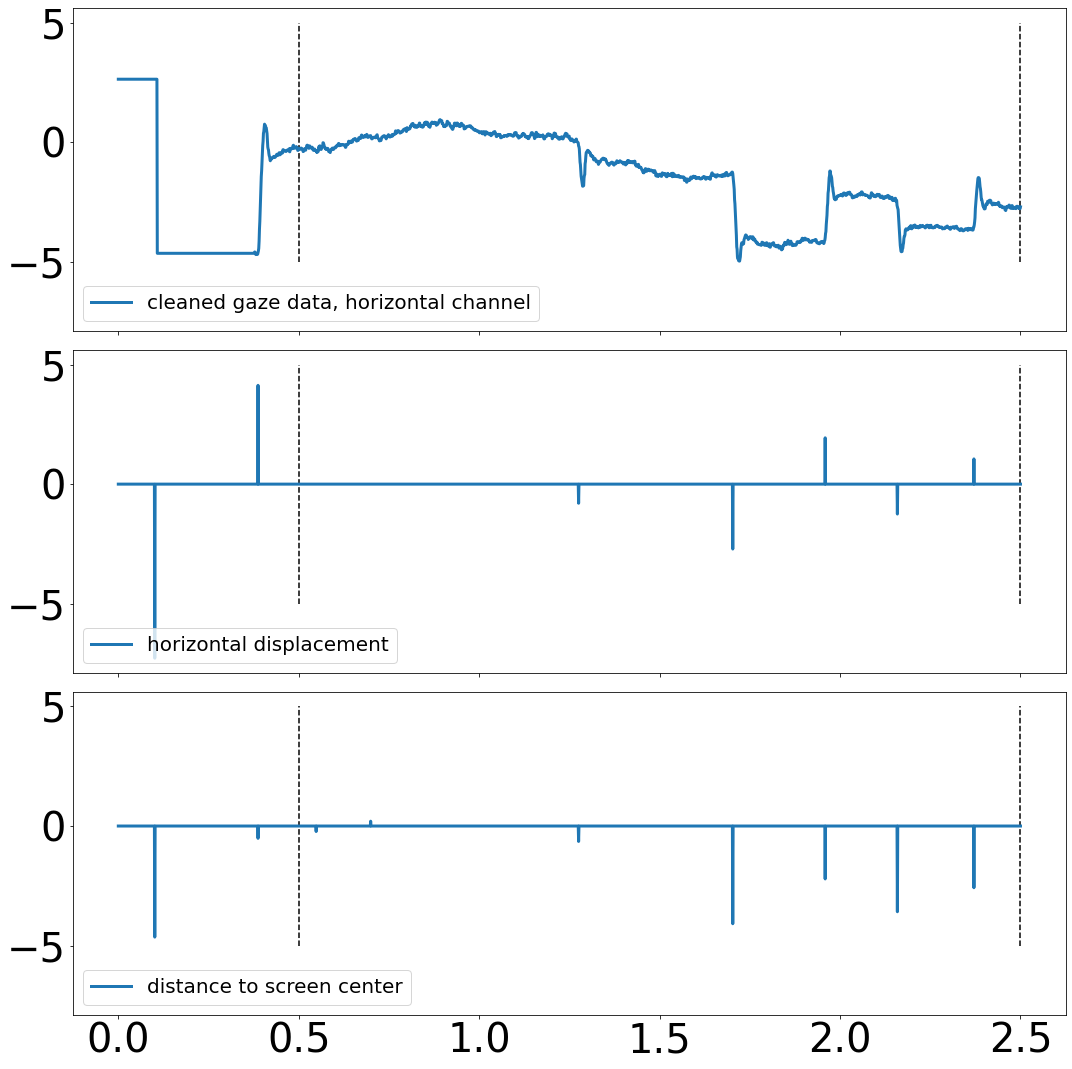

In [235]:
fs(15,15)

fig,ax = plt.subplots(nrows=3,sharex=True,sharey=True)
xAxis = np.linspace(0,2.5,2500)
ax[0].plot(xAxis,saccRetroX.iloc[ival,:2500],linewidth = 3,label = 'cleaned gaze data, horizontal channel')
ax[1].plot(xAxis,msRetroX.iloc[ival,:2500],linewidth = 3,label = 'horizontal displacement')
ax[2].plot(xAxis,msRetroX_ctr.iloc[ival,:2500],linewidth = 3,label = 'distance to screen center')

[ax[i].vlines([0.5,2.5],-5,5,linestyles = 'dashed',colors = 'black') for i in range(3)]
ax[0].legend(fontsize = 20,loc = 'lower left')
ax[1].legend(fontsize = 20,loc = 'lower left')
ax[2].legend(fontsize = 20,loc = 'lower left')
[ax[i].tick_params(labelsize = 40) for i in range(3)]

plt.tight_layout()

# save

## dataset 1

In [ ]:
#save gaze, for retrocue period
saccRetroBL.to_csv('Z:/LiteBrite_Yueying/data4Paper/cleanSacc_parsedByEventMarker/rej7Subj/cleanSacc_retrocueBL500ms.csv')
saccRetro.to_csv('Z:/LiteBrite_Yueying/data4Paper/cleanSacc_parsedByEventMarker/rej7Subj/cleanSacc_retrocue2Probe.csv')

In [ ]:
#save the microsaccade data, for retrocue epoch

#shift distance relative to each identified shift (aft. - bef.)
msRetroX_toward.to_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeShift2d/rej7Subj/gsRelX_towardRetro.csv')
msRetroX_away.to_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeShift2d/rej7Subj/gsRelX_awayRetro.csv')

#shift distance relative to screen center (aft. - 0)
msRetroX_ctr.to_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeShift2d/rej7Subj/gsCtrX_retro.csv')

#the frequency of identified shifts, toward&away
towardRetroX.to_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeShift2d/rej7Subj/freqRelX_towardRetro.csv')
awayRetroX.to_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeshift2d/rej7Subj/freqRelX_awayRetro.csv')

## dataset 2

In [ ]:
saccRetroBL_method2.to_csv('Z:/LiteBrite_Yueying/data4Paper/cleanSacc_parsedByEventMarker/cleanSacc_retrocueBL500ms.csv')
saccRetro_method2.to_csv('Z:/LiteBrite_Yueying/data4Paper/cleanSacc_parsedByEventMarker/cleanSacc_retrocue2Probe.csv')

In [ ]:
#save the microsaccade data, for retrocue epoch

#shift distance relative to each identified shift (aft. - bef.)
msRetroX_toward_method2.to_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeShift2d/gsRelX_towardRetro.csv')
msRetroX_away_method2.to_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeShift2d/gsRelX_awayRetro.csv')

#shift distance relative to screen center (aft. - 0)
msRetroX_ctr_method2.to_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeShift2d/gsCtrX_retro.csv')

#the frequency of identified shifts, toward&away
towardRetroX_method2.to_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeShift2d/freqRelX_towardRetro.csv')
awayRetroX_method2.to_csv('Z:/LiteBrite_YueyingDong/data4Paper/gazeshift2d/freqRelX_awayRetro.csv')